In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
import datetime

import gymnasium as gym
import torch

from policy_based import PolicyNetFunc, PolicyNetTrainer, PolicyNetTester, PolicyNetTrainerWithBase, ValueNetFunc
from deep_q import Discrete1ContinuousAction
from env import Env, get_action_discreter
from utils import clear_target_path, show_gif_on_jupyternb, to_gif
from train_test_util import start_test, start_train, StandarTestProcess, StandarTrainProcess

### 使用CarPole-V1 环境，测试Policy-Based REINFORCE 算法

In [ ]:
GYM_ENV_NAME = 'CartPole-v1'
env = Env.from_env_name(GYM_ENV_NAME)
RESULT_DIR_NAME='cartpoleV1'

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/REINFORCE')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/REINFORCE.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/REINFORCE')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()


TRAIN_EPOCH = 1000
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   env.get_action_dim()[0], 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainer(policy_func=policy_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH)

#### 训练模型

In [ ]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

#### 开始测试

In [ ]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用CarPole-V1 环境，测试Policy-Based + 基线的 REINFORCE 算法

In [2]:
GYM_ENV_NAME = 'CartPole-v1'
RESULT_DIR_NAME='cartpoleV1'
env = Env.from_env_name(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/REINFORCE_With_BASE')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/REINFORCE_With_BASE.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/REINFORCE_With_BASE')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()


TRAIN_EPOCH = 1000
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
VALUE_LEARNING_RATE = 1e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

value_func = ValueNetFunc(
                env.get_state_dim()[0], 
                hidden_dim=HIDDEN_DIM, 
                device=torch.device('cuda') if _USE_CUDA else None)

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   env.get_action_dim()[0], 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainerWithBase(
                                  policy_func=policy_func,
                                  value_func=value_func,
                                  value_learning_rate=LEARNING_RATE,
                                  env=env,
                                  learning_rate=VALUE_LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH)

INFO     | env: - action: 2, space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32); 2024-06-26 09:53:35 print_state_action_dims:68


#### 训练模型

In [3]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

INFO     | train_test_util: - start training, now datetime: 2024-06-26 09:53:37.244360; 2024-06-26 09:53:37 start_train:49
INFO     | train_test_util: - First, clean log path: run\logs\cartpoleV1\REINFORCE_With_BASE, and clean model path: run\model\cartpoleV1\REINFORCE_With_BASE.pth; 2024-06-26 09:53:37 start_train:50
INFO     | utils: - clear_target_path: run\logs\cartpoleV1\REINFORCE_With_BASE dose not exist; 2024-06-26 09:53:37 clear_target_path:38
INFO     | train_test_util: - train started; 2024-06-26 09:53:37 start_train:55


100%|██████████| 1000/1000 [00:17<00:00, 55.63it/s, reward=45.00, step=45] 

INFO     | train_test_util: - end training, now datetime: 2024-06-26 09:53:55.227945; 2024-06-26 09:53:55 start_train:57
INFO     | train_test_util: - saving model to: run\model\cartpoleV1\REINFORCE_With_BASE.pth,; 2024-06-26 09:53:55 start_train:63


#### 测试模型

Test Reward: 379.0
Step Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

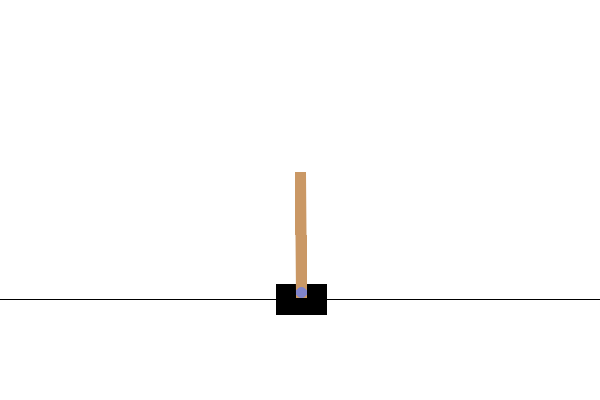

In [4]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用Pendulum-v1 环境，测试Policy-Based REINFORCE 算法

In [ ]:
GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1'

env = Env.from_env_name(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/policy_based')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/policy_model.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}_policy')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 1000
HIDDEN_DIM = 512
LEARNING_RATE = 1e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   action_nums=BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainer(policy_func=policy_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH,
                                  action_converter=get_action_discreter(env, BINS))

#### 训练模型

In [ ]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

#### 开始测试

In [ ]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env,
    action_converter=get_action_discreter(env, BINS)
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用Pendulum-v1 环境，测试Policy-Based + 基线的 REINFORCE 算法

In [ ]:
GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1'

env = Env.from_env_name(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/REINFORCE_With_BASE')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/REINFORCE_With_BASE.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/REINFORCE_With_BASE')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 3000
HIDDEN_DIM = 512
LEARNING_RATE = 5e-4
VALUE_LEARNING_RATE = 5e-3
GAMMA = 0.999

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

value_func = ValueNetFunc(
                env.get_state_dim()[0], 
                hidden_dim=HIDDEN_DIM, 
                device=torch.device('cuda') if _USE_CUDA else None)

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   action_nums=BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainerWithBase(
                                  policy_func=policy_func,
                                  value_func=value_func,
                                  value_learning_rate=VALUE_LEARNING_RATE,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH,
                                  action_converter=get_action_discreter(env, BINS))

#### 训练模型

In [ ]:
start_train(StandarTrainProcess(
    trainer=policy_func_trainer,
    model=policy_func,
    train_epoch=TRAIN_EPOCH,
    log_path=LOG_PATH,
    model_path=MODEL_PATH
))

#### 测试模型

In [ ]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env,
    action_converter=get_action_discreter(_render_env, BINS),
    stochastic=True
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)

### 使用CarPole-V1 环境，测试Policy-Based AC 算法

In [6]:
from policy_based import PolicyValueNetTrainer, ActionStateValueNetFunc

GYM_ENV_NAME = 'CartPole-v1'
RESULT_DIR_NAME='cartpoleV1'
env = Env.from_env_name(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/AC')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/AC/AC.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}/AC')

# 打印查看环境的动作空间和状态空间 
env.print_state_action_dims()

TRAIN_EPOCH = 1000
HIDDEN_DIM = 512
LEARNING_RATE = 1e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(env.get_state_dim()[0], 
                   action_nums=env.get_action_dim()[0], 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)

value_func = ActionStateValueNetFunc(env.get_state_dim()[0],
                          action_nums=env.get_action_dim()[0],
                          hidden_dim=HIDDEN_DIM,
                          device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyValueNetTrainer(
                                  policy_func=policy_func,
                                  value_func=value_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH
                                  )

INFO     | env: - action: 2, space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32); 2024-06-26 05:43:01 print_state_action_dims:68


#### 开始训练

In [7]:
start_train(
    StandarTrainProcess(
        trainer=policy_func_trainer,
        model=policy_func,
        train_epoch=TRAIN_EPOCH,
        log_path=LOG_PATH,
        model_path=MODEL_PATH
    )
)

INFO     | train_test_util: - start training, now datetime: 2024-06-26 05:43:02.802959; 2024-06-26 05:43:02 start_train:49
INFO     | train_test_util: - First, clean log path: run/logs/cartpoleV1/AC, and clean model path: run/model/cartpoleV1/AC/AC.pth; 2024-06-26 05:43:02 start_train:50
INFO     | train_test_util: - train started; 2024-06-26 05:43:02 start_train:55


100%|██████████| 1000/1000 [00:25<00:00, 39.12it/s, reward=124.00, step=124]

INFO     | train_test_util: - end training, now datetime: 2024-06-26 05:43:28.375065; 2024-06-26 05:43:28 start_train:57
INFO     | train_test_util: - saving model to: run/model/cartpoleV1/AC/AC.pth,; 2024-06-26 05:43:28 start_train:63


Test Reward: 77.0
Step Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


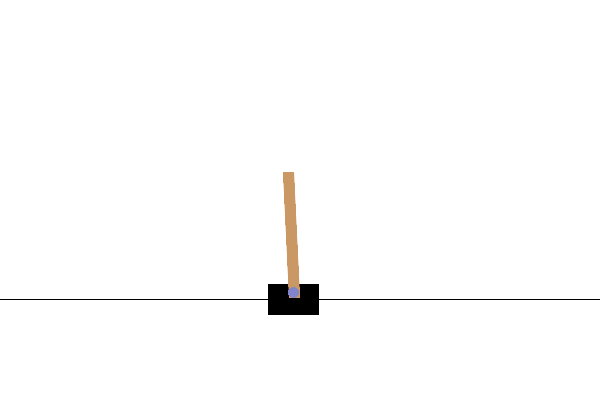

In [8]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))

policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func,
    env=_render_env
)


start_test(
    StandarTestProcess(
        model=test_policy_func,
        tester=policy_func_tester,
        env=_render_env,
        test_output_path=TEST_OUTPUT_PATH,
        test_epoch=1000,
    )
)